# flowField class for iterative solution

In [ ]:
import scipy as sp
import numpy as np
from pseudo import *

f = np.genfromtxt('eq1.asc',dtype=np.complex)
f_p = np.genfromtxt('peq1.asc',dtype=np.complex)
   
x = f[:,3];x_p = f_p[:,3]

# From the database at channelflow.org
Re=4.0e2
a=1.14
b=2.5

nx = 48
nz = 25
L = 24
M = 24
N = 35

# In input file, ordering of modes is different from what I would like it to be.
# It goes, 0,1,..,24,-23,-22,....,-1 in 'x'
# I prefer, -23,-22,..,-1,0,1,...,22,23
# In 'z', it's just 0,..,24 
#     Negative wavenumbers are not included due to symmetry.

# First, getting rid of mode 24 in both x and z 
modes = x.reshape((nx,nz,3,N))
modes = sp.append(modes,x_p.reshape((nx,nz,1,N)),axis=2)
modes = sp.delete(modes,L,0)
modes = sp.delete(modes,M,1)
nx = nx-1 
nz = nz-1
L = L-1
M = M-1

# Now, reordering streamwise wavenumbers
modes = sp.append(modes[L+1:,:,:,:],modes[:L+1,:,:,:],0)
del x,x_p,f,f_p

# Projecting Cheb coefficients onto Cheb collocation nodes
for kx in range(0,nx):
    for kz in range(0,nz):
        for nd in range(0,4):
            modes[kx,kz,nd,:] = chebcoll_vec(modes[kx,kz,nd,:])

# Adding modes for negative spanwise wavenumbers. 
modes = sp.append(modes[::-1,:0:-1].conjugate(),modes,axis=1)
nz = nx

# Deleting pressure from state-vector:
p = modes[:,:,3]
modes = sp.delete(modes,3,2)

vecsize = nx*nz*N
# Finally, reshaping to get a state-vector containing u and w
x0 = modes.reshape(3*vecsize)
p = p.reshape(vecsize)
del modes
#print(modes[L,M,0])


## Reading data from .mat files into flowFieldArray class instance
Makes it easier to calculate variables, and to plot

1. Reading .mat files from a folder, according to a template, into a Python list
2. Converting that Python list into flowFieldArray instance (class defined in module flowFieldArray.py)

In [1]:
# Reading all the .mat files takes a while, so this chunk of code needs to be separate from the other stuff
import glob
import os
from flowFieldWavy import *
from flowFieldArray import *
from flowField import *

# These two lines allow iPython to reload modules before executing
%load_ext autoreload
%autoreload 2

theta='0'
homeFolder = '/home/sabarish/Dropbox/gitwork/python3/flowField/'
folderPath = '/home/sabarish/matData/drag/'
fileTemplate = "data_dragT"+theta+"E*.mat" 

os.chdir(folderPath)
fileList = glob.glob(fileTemplate)
for file in fileList[:]:
    if (file[-6:] =='13.mat') or (file[-6:] =='14.mat') or (file[-6:] =='15.mat'):
        #print(file)
        fileList.remove(file)

vListLong =[]; pListLong = []
for file in fileList:
    vList,pList = data2ff(file)[:2]
    vListLong.extend(vList)
    pListLong.extend(pList)
os.chdir(homeFolder)

In [2]:
pArr =  flowFieldArray(pListLong,26,24,21)

In [3]:
#from flowFieldWavy import *
# Create flowFieldArray instance out of the list of flowField instances
vArr = flowFieldArray(vListLong,26,24,21)

print(isinstance(vArr[0,0,0].field, flowField))
# To obtain a 3-d array of, say, volume fluxes of the data in the flowFieldArray:
fluxArr = vArr.getProperty('flux',withBase=True)
#ReTauArr = vArr.getProperty('ReTau')


True


In [21]:
#from seprn import seprn
#%load_ext autoreload
#%autoreload 2

xs = np.zeros(vArr.shape,dtype=np.float)
xr = xs.copy(); ybub=xs.copy(); sflag = np.zeros(vArr.shape,dtype=np.int)

for ke in range(xs.shape[0]):
    for kg in range(xs.shape[1]):
        for kr in range(xs.shape[2]):
            x = vArr[ke,kg,kr].field.addBase().appendField(pArr[ke,kg,kr].field).view1d()
            N = x.N; n = x.flowDict['L']; a = x.flowDict['alpha']; b=x.flowDict['beta'];Re=x.flowDict['Re']; eps=x.flowDict['eps']
            x = x.copyArray()
            sf,sp,rp,yb = seprn(x,N,n,eps,a,b,Re)
            xs[ke,kg,kr] = sp; xr[ke,kg,kr] = rp; ybub[ke,kg,kr] = yb; sflag[ke,kg,kr] = sf


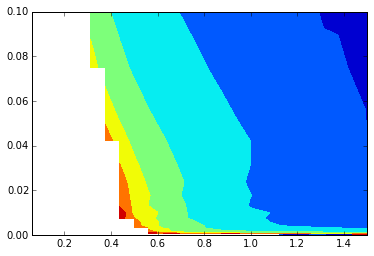

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline
epsArr = vArr[:,:,0].getProperty('eps')
gArr = vArr[:,:,0].getProperty('g')

plt.figure()
plt.contourf(2.*gArr,2.*epsArr,xs[:,:,10])
plt.colorbar()
plt.show()

In [ ]:
plt.figure()
plt.title('Location of separation point, $Re_{\\tau}=4.5$')
plt.contourf(2.*gArr,2.*epsArr,xs[:,:,0],levels=np.arange(0.,0.55,0.05))
plt.xlabel('Slope');plt.ylabel('Amplitude')
plt.colorbar()
plt.savefig('./figures/xSepReT4.pdf',format='pdf')
plt.show()

plt.figure()
plt.title('Location of separation point, $Re_{\\tau}=8$')
plt.contourf(2.*gArr,2.*epsArr,xs[:,:,5],levels=np.arange(0.,0.55,0.05))
plt.xlabel('Slope');plt.ylabel('Amplitude')
plt.colorbar()
plt.savefig('./figures/xSepReT8.pdf',format='pdf')
plt.show()

plt.figure()
plt.title('Location of separation point, $Re_{\\tau}=14.1$')
plt.contourf(2.*gArr,2.*epsArr,xs[:,:,10],levels=np.arange(0.,0.55,0.05))
plt.xlabel('Slope');plt.ylabel('Amplitude')
plt.colorbar()
plt.savefig('./figures/xSepReT14.pdf',format='pdf')
plt.show()

plt.figure()
plt.title('Location of separation point, $Re_{\\tau}=45$')
plt.contourf(2.*gArr,2.*epsArr,xs[:,:,20],levels=np.arange(0.,0.55,0.05))
plt.xlabel('Slope');plt.ylabel('Amplitude')
plt.colorbar()
plt.savefig('./figures/xSepReT45.pdf',format='pdf')
plt.show()

plt.figure()
plt.title('Location of Reattachment point, $Re_{\\tau}=4.5$')
plt.contourf(2.*gArr,2.*epsArr,xr[:,:,0],levels=np.arange(0.5,1.05,0.05))
plt.xlabel('Slope');plt.ylabel('Amplitude')
plt.colorbar()
plt.savefig('./figures/xReatReT4.pdf',format='pdf')
plt.show()

plt.figure()
plt.title('Location of Reattachment point, $Re_{\\tau}=8$')
plt.contourf(2.*gArr,2.*epsArr,xr[:,:,5],levels=np.arange(0.5,1.05,0.05))
plt.xlabel('Slope');plt.ylabel('Amplitude')
plt.colorbar()
plt.savefig('./figures/xReatReT8.pdf',format='pdf')
plt.show()

plt.figure()
plt.title('Location of Reattachment point, $Re_{\\tau}=14.1$')
plt.contourf(2.*gArr,2.*epsArr,xr[:,:,10],levels=np.arange(0.5,1.05,0.05))
plt.xlabel('Slope');plt.ylabel('Amplitude')
plt.colorbar()
plt.savefig('./figures/xReatReT14.pdf',format='pdf')
plt.show()

plt.figure()
plt.title('Location of Reattachment point, $Re_{\\tau}=45$')
plt.contourf(2.*gArr,2.*epsArr,xr[:,:,20],levels=np.arange(0.5,1.05,0.05))
plt.xlabel('Slope');plt.ylabel('Amplitude')
plt.colorbar()
plt.savefig('./figures/xReatReT45.pdf',format='pdf')
plt.show()

plt.figure()
plt.title('Separation bubble height, $Re_{\\tau}=4.5$')
plt.contourf(2.*gArr,2.*epsArr,ybub[:,:,0],levels=np.arange(0.,1.05,0.05))
plt.xlabel('Slope');plt.ylabel('Amplitude')
plt.colorbar()
plt.savefig('./figures/ybubReT4.pdf',format='pdf')
plt.show()

plt.figure()
plt.title('Separation bubble height, $Re_{\\tau}=8$')
plt.contourf(2.*gArr,2.*epsArr,ybub[:,:,5],levels=np.arange(0.,1.05,0.05))
plt.xlabel('Slope');plt.ylabel('Amplitude')
plt.colorbar()
plt.savefig('./figures/ybubReT8.pdf',format='pdf')
plt.show()

plt.figure()
plt.title('Separation bubble height, $Re_{\\tau}=14.1$')
plt.contourf(2.*gArr,2.*epsArr,ybub[:,:,10],levels=np.arange(0.,1.05,0.05))
plt.xlabel('Slope');plt.ylabel('Amplitude')
plt.colorbar()
plt.savefig('./figures/ybubReT14.pdf',format='pdf')
plt.show()

plt.figure()
plt.title('Separation bubble height, $Re_{\\tau}=45$')
plt.contourf(2.*gArr,2.*epsArr,xr[:,:,20],levels=np.arange(0.,1.05,0.05))
plt.xlabel('Slope');plt.ylabel('Amplitude')
plt.colorbar()
plt.savefig('./figures/ybubReT45.pdf',format='pdf')
plt.show()


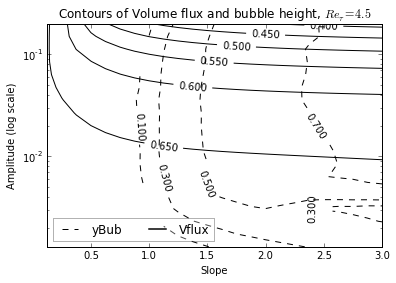

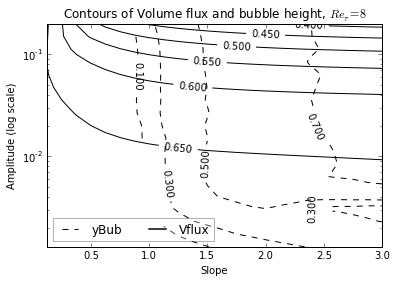

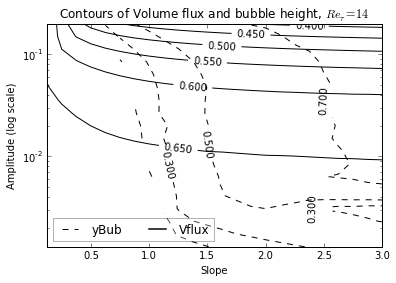

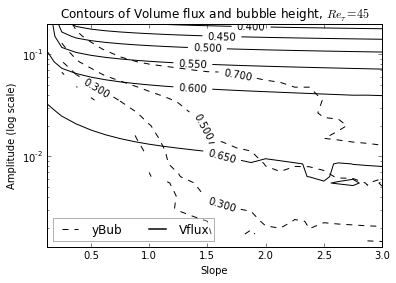

In [67]:
#fluxArr = vArr.getProperty('flux',withBase=True)

import matplotlib.lines as mlines
eOff = 7
plt.figure()
ax = plt.gca()
plt.title ('Contours of Volume flux and bubble height, $Re_{\\tau}=4.5$')
plt.xlabel ('Slope');  plt.ylabel ('Amplitude (log scale)')
ax.set_yscale('log')
CF = plt.contour(2.*gArr[eOff:],2.*epsArr[eOff:],fluxArr[eOff:,:,0],levels=[0.4,0.45,0.5,0.55,0.6,0.65],colors = 'k')
plt.clabel(CF)
plt.draw()

CF = plt.contour(2.*gArr[eOff:],2.*epsArr[eOff:],ybub[eOff:,:,0],levels=[0.1,0.3,0.5,0.7],colors = 'k',linestyles = 'dashed')
plt.clabel(CF)
plt.draw()

black_line = mlines.Line2D([], [], color='k', label='Vflux',linewidth = 1.5)
dashed_line = mlines.Line2D([], [], color='k', label='yBub',linewidth = 1,linestyle = '--')
plt.legend(handles=[dashed_line,black_line],framealpha = 0.3,loc = 'lower left', ncol = 2)#bbox_to_anchor=(0.24, 0.20),)
plt.savefig('./figures/vFluxYbubReT4.pdf',format='pdf')
plt.show()



plt.figure()
ax = plt.gca()
plt.title ('Contours of Volume flux and bubble height, $Re_{\\tau}=8$')
plt.xlabel ('Slope');  plt.ylabel ('Amplitude (log scale)')
ax.set_yscale('log')
CF = plt.contour(2.*gArr[eOff:],2.*epsArr[eOff:],fluxArr[eOff:,:,5],levels=[0.4,0.45,0.5,0.55,0.6,0.65],colors = 'k')
plt.clabel(CF)
plt.draw()

CF = plt.contour(2.*gArr[eOff:],2.*epsArr[eOff:],ybub[eOff:,:,5],levels=[0.1,0.3,0.5,0.7],colors = 'k',linestyles = 'dashed')
plt.clabel(CF)
plt.draw()

black_line = mlines.Line2D([], [], color='k', label='Vflux',linewidth = 1.5)
dashed_line = mlines.Line2D([], [], color='k', label='yBub',linewidth = 1,linestyle = '--')
plt.legend(handles=[dashed_line,black_line],framealpha = 0.3,loc = 'lower left', ncol = 2)#bbox_to_anchor=(0.24, 0.20),)
plt.savefig('./figures/vFluxYbubReT8.pdf',format='pdf')
plt.show()



plt.figure()
ax = plt.gca()
plt.title ('Contours of Volume flux and bubble height, $Re_{\\tau}=14$')
plt.xlabel ('Slope');  plt.ylabel ('Amplitude (log scale)')
ax.set_yscale('log')
CF = plt.contour(2.*gArr[eOff:],2.*epsArr[eOff:],fluxArr[eOff:,:,10],levels=[0.4,0.45,0.5,0.55,0.6,0.65],colors = 'k')
plt.clabel(CF)
plt.draw()

CF = plt.contour(2.*gArr[eOff:],2.*epsArr[eOff:],ybub[eOff:,:,10],levels=[0.1,0.3,0.5,0.7],colors = 'k',linestyles = 'dashed')
plt.clabel(CF)
plt.draw()

black_line = mlines.Line2D([], [], color='k', label='Vflux',linewidth = 1.5)
dashed_line = mlines.Line2D([], [], color='k', label='yBub',linewidth = 1,linestyle = '--')
plt.legend(handles=[dashed_line,black_line],framealpha = 0.3,loc = 'lower left', ncol = 2)#bbox_to_anchor=(0.24, 0.20),)
plt.savefig('./figures/vFluxYbubReT14.pdf',format='pdf')
plt.show()



plt.figure()
ax = plt.gca()
plt.title ('Contours of Volume flux and bubble height, $Re_{\\tau}=45$')
plt.xlabel ('Slope');  plt.ylabel ('Amplitude (log scale)')
ax.set_yscale('log')
CF = plt.contour(2.*gArr[eOff:],2.*epsArr[eOff:],fluxArr[eOff:,:,20],levels=[0.4,0.45,0.5,0.55,0.6,0.65],colors = 'k')
plt.clabel(CF)
plt.draw()

CF = plt.contour(2.*gArr[eOff:],2.*epsArr[eOff:],ybub[eOff:,:,20],levels=[0.1,0.3,0.5,0.7],colors = 'k',linestyles = 'dashed')
plt.clabel(CF)
plt.draw()

black_line = mlines.Line2D([], [], color='k', label='Vflux',linewidth = 1.5)
dashed_line = mlines.Line2D([], [], color='k', label='yBub',linewidth = 1,linestyle = '--')
plt.legend(handles=[dashed_line,black_line],framealpha = 0.3,loc = 'lower left', ncol = 2)#bbox_to_anchor=(0.24, 0.20),)
plt.savefig('./figures/vFluxYbubReT45.pdf',format='pdf')
plt.show()





In [5]:
#ReTauArr = vArr.getProperty('ReTau')
ReArr = vArr.getProperty('Re')
#fluxArr = vArr.getProperty('flux',withBase=True)
uBulk = fluxArr; ReFlat = ReArr
print(ReFlat.shape, uBulk.shape, type(ReFlat), type(uBulk))
fricFac = 16./ReFlat/uBulk/uBulk
ReWavy = uBulk*ReFlat

(26, 24, 21) (26, 24, 21) <class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [7]:
epsArr = vArr.getProperty('eps'); gArr = vArr.getProperty('g')

[ 0.00048697  0.01        0.03162278]
[ 0.125   0.75    1.4375]


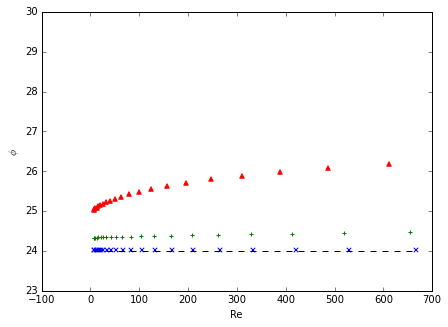

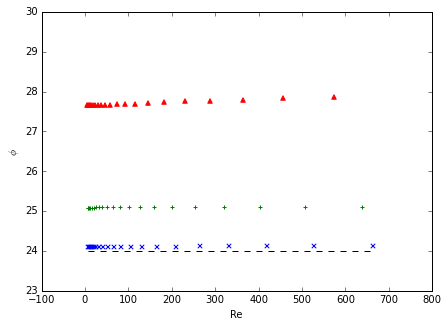

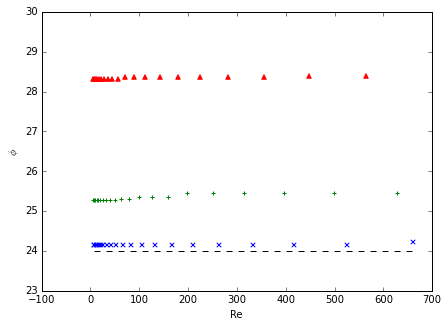

phiMean, phiDev: 25.609386624 0.578279043765


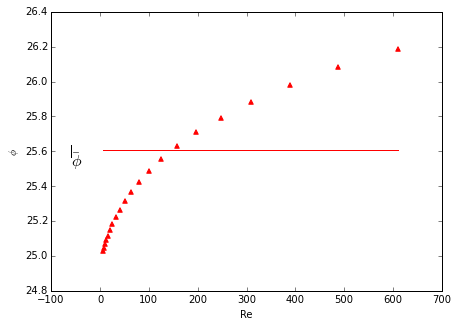

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline
phiArr = ReWavy*fricFac
keArr = np.asarray([6,17,21]);kgArr = np.asarray([1,11,22]); nRe=ReWavy.shape[2]
print(epsArr[keArr,0,0])
print(gArr[0,kgArr,0])

markers = ['x','+','^']

kg=kgArr[0]
fig = plt.figure(figsize=(7,5))
ax0 = fig.add_subplot(111)
plt.xlabel('Re'); plt.ylabel('$\\phi$')
plt.ylim([23.,30.])
plt.xlim([-100,700])

ax4,=ax0.plot(ReWavy[keArr[0],kg,:], 24.*np.ones(nRe),linestyle='--',color='k')
plt.savefig('./figures/phiRe0.pdf',format='pdf')

ax1=ax0.scatter(ReWavy[keArr[0],kg,:], phiArr[keArr[0],kg,:], marker=markers[0],color='b')
plt.savefig('./figures/phiRe11.pdf',format='pdf')

ax2=ax0.scatter(ReWavy[keArr[1],kg,:], phiArr[keArr[1],kg,:], marker=markers[1],color='g')
plt.savefig('./figures/phiRe12.pdf',format='pdf')

ax3=ax0.scatter(ReWavy[keArr[2],kg,:], phiArr[keArr[2],kg,:], marker=markers[2],color='r')
plt.savefig('./figures/phiRe13.pdf',format='pdf')


kg=kgArr[1]
fig = plt.figure(figsize=(7,5))
ax0 = fig.add_subplot(111)
plt.xlabel('Re'); plt.ylabel('$\\phi$')
plt.ylim([23.,30.])

ax4,=ax0.plot(ReWavy[keArr[0],kg,:], 24.*np.ones(nRe),linestyle='--',color='k')
plt.savefig('./figures/phiRe0.pdf',format='pdf')

ax1=ax0.scatter(ReWavy[keArr[0],kg,:], phiArr[keArr[0],kg,:], marker=markers[0],color='b')
plt.savefig('./figures/phiRe21.pdf',format='pdf')

ax2=ax0.scatter(ReWavy[keArr[1],kg,:], phiArr[keArr[1],kg,:], marker=markers[1],color='g')
plt.savefig('./figures/phiRe22.pdf',format='pdf')

ax3=ax0.scatter(ReWavy[keArr[2],kg,:], phiArr[keArr[2],kg,:], marker=markers[2],color='r')
plt.savefig('./figures/phiRe23.pdf',format='pdf')


kg=kgArr[2]
fig = plt.figure(figsize=(7,5))
ax0 = fig.add_subplot(111)
plt.xlabel('Re'); plt.ylabel('$\\phi$')
plt.ylim([23.,30.])

ax4,=ax0.plot(ReWavy[keArr[0],kg,:], 24.*np.ones(nRe),linestyle='--',color='k')
#plt.savefig('./figures/phiRe0.pdf',format='pdf')

ax1=ax0.scatter(ReWavy[keArr[0],kg,:], phiArr[keArr[0],kg,:], marker=markers[0],color='b')
plt.savefig('./figures/phiRe31.pdf',format='pdf')

ax2=ax0.scatter(ReWavy[keArr[1],kg,:], phiArr[keArr[1],kg,:], marker=markers[1],color='g')
plt.savefig('./figures/phiRe32.pdf',format='pdf')

ax3=ax0.scatter(ReWavy[keArr[2],kg,:], phiArr[keArr[2],kg,:], marker=markers[2],color='r')
plt.savefig('./figures/phiRe33.pdf',format='pdf')

plt.show()

kg = kgArr[0]
fig = plt.figure(figsize=(7,5))
ax0 = fig.add_subplot(111)
plt.xlabel('Re'); plt.ylabel('$\\phi$')

ax3=ax0.scatter(ReWavy[keArr[2],kg,:], phiArr[keArr[2],kg,:], marker=markers[2],color='r')
phiMean = 0.5*(np.min(phiArr[keArr[2],kg,:])+np.max(phiArr[keArr[2],kg,:]))
phiDev = np.max(phiArr[keArr[2],kg,:]) - phiMean
print('phiMean, phiDev:',phiMean,phiDev)
ax4=ax0.plot(ReWavy[keArr[2],kg,:],phiMean*np.ones(nRe), color='r')

plt.annotate('$\\bar{\\phi}$',xy = (0.05,0.5),xycoords='axes fraction', 
             xytext=(0.05,0.5),textcoords='axes fraction',
             arrowprops=dict(facecolor='white',shrink=0.000,width=0.0),
            horizontalalignment='left', verticalalignment='top',fontsize=16)

plt.savefig('./figures/phiRe4.jpeg',format='jpeg')

plt.show()



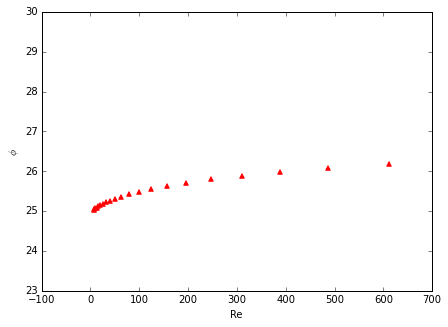

phiMean, phiDev: 25.609386624 0.578279043765


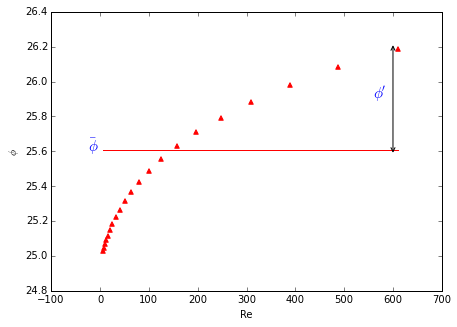

In [53]:
kg=kgArr[0]
fig = plt.figure(figsize=(7,5))
ax0 = fig.add_subplot(111)
plt.xlabel('Re'); plt.ylabel('$\\phi$')
plt.ylim([23.,30.])
ax3=ax0.scatter(ReWavy[keArr[2],kg,:], phiArr[keArr[2],kg,:], marker=markers[2],color='r')
plt.savefig('./figures/phiRe40.pdf',format='pdf')
plt.show()

fig = plt.figure(figsize=(7,5))
ax0 = fig.add_subplot(111)
plt.xlabel('Re'); plt.ylabel('$\\phi$')
ax3=ax0.scatter(ReWavy[keArr[2],kg,:], phiArr[keArr[2],kg,:], marker=markers[2],color='r')
plt.savefig('./figures/phiRe41.pdf',format='pdf')

phiMean = 0.5*(np.min(phiArr[keArr[2],kg,:])+np.max(phiArr[keArr[2],kg,:]))
phiDev = np.max(phiArr[keArr[2],kg,:]) - phiMean
print('phiMean, phiDev:',phiMean,phiDev)
ax4=ax0.plot(ReWavy[keArr[2],kg,:],phiMean*np.ones(nRe), color='r')
plt.text(-25,25.6,'$\\bar{\\phi}$',fontsize=15,color='blue')
plt.savefig('./figures/phiRe42.pdf',format='pdf')

plt.annotate("",xy=(600,26.22),xycoords='data',
            xytext=(600,25.58),textcoords='data',
             arrowprops={'arrowstyle':'<->'})
plt.text(560,25.9,"$\\phi'$",fontsize=15,color='blue')
plt.savefig('./figures/phiRe43.pdf',format='pdf')
plt.show()


In [54]:
phiMean = 0.5*(np.min(phiArr,axis=2)+np.max(phiArr,axis=2))
phiDev = 0.5*(np.max(phiArr,axis=2)-np.min(phiArr,axis=2))

## Curve fitting

- We're looking for a relation that goes as $\lambda = a Re^{-n}$, where $a$ and $n$ are functions of $g,\epsilon$. 
- From earlier work by Adrien, we know $n \approx 1$ for $\epsilon$ holds for $4\epsilon$ not exceeding 15%.
- We just need to verify if $\lambda Re = const.$ holds up, and if it does, how we need to see how the constant varies with $g,\epsilon$.

### FIrst, checking if the inverse law holds

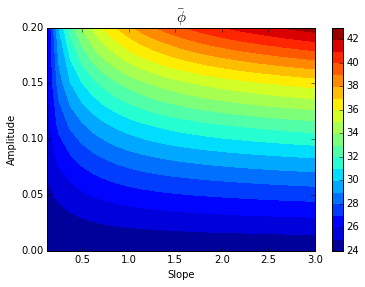

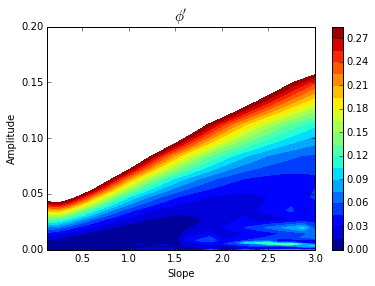

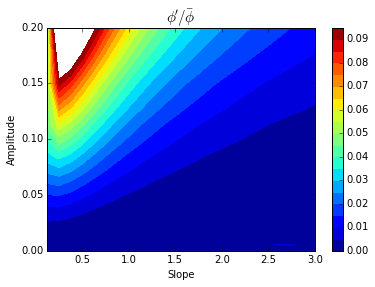

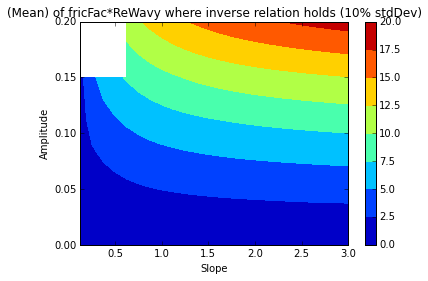

In [57]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline
#coloring = np.random.random(32).reshape((8,4))
#for k in range(0,8):
#    plt.scatter(np.log10(ReWavy[3*k,3*k]),10.**(np.log10(ReWavy[3*k,3*k])+ np.log10(fricFac[3*k,3*k])), c=coloring[k-3])
#plt.ylim([-0.006,0.])
#plt.show()

#theta='0'
#pp = PdfPages('InverseLaw'+theta+'.pdf')

#prod = fricFac*ReWavy         # This must be a constant for different ReWavy. 
prod = phiArr
# To see if it is indeed constant, I can look at the standard deviation at any g,eps:
#prod = prod[:,:,2:]

#stdDev = np.std(prod,axis=2)  # Computing standard deviation for lambda*Re at a constant g,eps, but varying Re
stdDev=phiDev

epsArr = vArr.getProperty('eps')
gArr = vArr.getProperty('g')
cutOff = 0

cLimits = np.arange(24., 44., 1.0)
#meanProd = np.mean(prod,axis=2)  # Computing mean for lambda*Re at a constant g,eps, but varying Re
meanProd = phiMean
plt.figure()
#plt.contourf(2.*gArr[:-cutOff,:,0], 4.*epsArr[:-cutOff,:,0], meanProd[:-cutOff],levels=cLimits)
plt.contourf(2.*gArr[:,:,0], 2.*epsArr[:,:,0], meanProd[:], levels=cLimits)
#plt.ylim([24.,44.])
#plt.clim(24.0,28.0)
plt.colorbar()
plt.title('$\\bar{\\phi}$',fontsize=15)
plt.xlabel('Slope');plt.ylabel('Amplitude')
#pp.savefig()
plt.savefig('./figures/mean.pdf',format='pdf')
plt.show()

cLimits= np.arange(0.0, 0.3, 0.015)
plt.figure()
plt.title("$\\phi'$",fontsize=15)
#plt.contourf(2.*gArr[:-cutOff,:,0], 4.*epsArr[:-cutOff,:,0], stdDev[:-cutOff], levels=cLimits)
plt.contourf(2.*gArr[:,:,0], 2.*epsArr[:,:,0], stdDev[:], levels=cLimits)
#plt.clim([0.,0.15])
#plt.clim(0.0,0.2)
plt.colorbar()
plt.xlabel('Slope');plt.ylabel('Amplitude')
#pp.savefig()
plt.savefig('./figures/std.pdf',format='pdf')
plt.show()


cLimits = np.arange(0.0,0.1,0.1/20)
#cLimits= np.append(cLimits,np.asarray([0.2,0.3,0.4,0.5,0.6,0.7]))
plt.figure()
plt.title("$\\phi'/\\bar{\\phi}$",fontsize=15)
#plt.contourf(2.*gArr[:,:,0], 2.*epsArr[:,:,0], stdDev[:]/(meanProd[:]-24),levels=cLimits)
plt.contourf(2.*gArr[:,:,0], 2.*epsArr[:,:,0], stdDev[:]/(meanProd[:]),levels=cLimits)
#plt.clim([0.,0.15])
#plt.clim(0.0,0.1)
plt.colorbar()
plt.xlabel('Slope');plt.ylabel('Amplitude')
plt.savefig('./figures/stdOverMean.pdf',format='pdf')
plt.show()
#plt.savefig('stdOverMeanT'+theta+'.pdf')

# Mean where stdDev/(mean-24) is small enough (<10%):
#cLimits = np.arange(0., 4., 0.25)
#stdOverMean = stdDev/(meanProd-24.)
stdOverMean = stdDev/(meanProd)
newMean = meanProd.copy()
newMean[stdOverMean>0.1] = None
plt.figure()
#plt.title('(Mean-24) of fricFac*ReWavy where inverse relation holds (10% stdDev)')
plt.title('(Mean) of fricFac*ReWavy where inverse relation holds (10% stdDev)')
plt.contourf(2.*gArr[:,:,0], 2.*epsArr[:,:,0], (newMean[:]-24))
plt.colorbar()
plt.xlabel('Slope');plt.ylabel('Amplitude')
plt.savefig('meanInverseLaw'+theta+'.pdf',format='pdf')
plt.show()




In [ ]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline
#coloring = np.random.random(32).reshape((8,4))
#for k in range(0,8):
#    plt.scatter(np.log10(ReWavy[3*k,3*k]),10.**(np.log10(ReWavy[3*k,3*k])+ np.log10(fricFac[3*k,3*k])), c=coloring[k-3])
#plt.ylim([-0.006,0.])
#plt.show()

#theta='0'
#pp = PdfPages('InverseLaw'+theta+'.pdf')

prod = fricFac*ReWavy         # This must be a constant for different ReWavy. 
# To see if it is indeed constant, I can look at the standard deviation at any g,eps:
#prod = prod[:,:,2:]
#meanProd = np.mean(prod,axis=2)  # Computing mean for lambda*Re at a constant g,eps, but varying Re
meanProd = 0.5*( prod[:,:,0] + prod[:,:,-1] )

#stdDev = np.std(prod,axis=2)  # Computing standard deviation for lambda*Re at a constant g,eps, but varying Re
stdDev = np.amax( np.abs( prod[:,:,:] -meanProd.reshape((prod.shape[0],prod.shape[1],1))  ) , axis=2 )

epsArr = vArr.getProperty('eps')
gArr = vArr.getProperty('g')
cutOff = 0

cLimits = np.arange(24., 44., 1.0)
plt.figure()
#plt.contourf(2.*gArr[:-cutOff,:,0], 4.*epsArr[:-cutOff,:,0], meanProd[:-cutOff],levels=cLimits)
plt.contourf(2.*gArr[:,:,0], 2.*epsArr[:,:,0], meanProd[:], levels=cLimits)
#plt.ylim([24.,44.])
#plt.clim(24.0,28.0)
plt.colorbar()
plt.title('$\\bar{\\phi}$: Mean of $\\phi(Re)$')
plt.xlabel('Slope');plt.ylabel('Amplitude')
#pp.savefig()
plt.savefig('mean.pdf',format='pdf')
plt.show()

#cLimits= np.arange(0.0, 0.3, 0.05)
plt.figure()
plt.title("$\\phi'$: Deviation of $\\phi(Re)$ from $\\bar{\\phi}$")
#plt.contourf(2.*gArr[:,:,0], 2.*epsArr[:,:,0], stdDev[:], levels=cLimits)
plt.contourf(2.*gArr[:,:,0], 2.*epsArr[:,:,0], stdDev[:],20)
#plt.clim([0.,0.15])
#plt.clim(0.0,2.0)
plt.colorbar()
plt.xlabel('Slope');plt.ylabel('Amplitude')
#pp.savefig()
plt.savefig('stdT'+theta+'.pdf',format='pdf')
plt.show()


cLimits = np.arange(0.0,0.15,0.1/20)
#cLimits= np.append(cLimits,np.asarray([0.2,0.3,0.4,0.5,0.6,0.7]))
plt.figure()
plt.title("$\\phi'/\\bar{\\phi}$: Relative deviation")
#plt.contourf(2.*gArr[:,:,0], 2.*epsArr[:,:,0], stdDev[:]/(meanProd[:]-24),levels=cLimits)
plt.contourf(2.*gArr[:,:,0], 2.*epsArr[:,:,0], stdDev[:]/(meanProd[:]),levels=cLimits)
#plt.clim([0.,0.15])
#plt.clim(0.0,0.1)
plt.colorbar()
plt.xlabel('Slope');plt.ylabel('Amplitude')
plt.savefig('stdOverMeanT'+theta+'.pdf',format='pdf')
plt.show()
#plt.savefig('stdOverMeanT'+theta+'.pdf')

# Mean where stdDev/(mean-24) is small enough (<10%):
#cLimits = np.arange(0., 4., 0.25)
#stdOverMean = stdDev/(meanProd-24.)
stdOverMean = stdDev/(meanProd)
newMean = meanProd.copy()
newMean[stdOverMean>0.1] = None
plt.figure()
#plt.title('(Mean-24) of fricFac*ReWavy where inverse relation holds (10% stdDev)')
plt.title('(Mean) of fricFac*ReWavy where inverse relation holds (10% stdDev)')
plt.contourf(2.*gArr[:,:,0], 2.*epsArr[:,:,0], (newMean[:]-24))
plt.colorbar()
plt.xlabel('Slope');plt.ylabel('Amplitude')
plt.savefig('meanInverseLaw'+theta+'.pdf',format='pdf')
plt.show()


In [ ]:
plt.figure()
lArr = np.random.rand(120).reshape(30,4)
symArr = ["o","v","s","^","*","x","+"]
symArr.extend(symArr);symArr.extend(symArr);
printFolder = '/home/sabarish/Dropbox/reports/2015/transfer/figures/'
'''
for k in range(21):
    #plt.scatter(np.log10(2.*gArr[k,:,0]),np.log10(meanProd[k,:]-24.), color=lArr[k])
    plt.scatter(2.*gArr[k,:,0],(meanProd[k,:]-24.), color=lArr[k])
plt.show()
'''
plt.figure()
#ax = plt.subplot(111)
#ax = plt.axes()
plt.annotate('Slope',xy = (0.4,0.7),xycoords='axes fraction', 
             xytext=(0.7,0.1),textcoords='axes fraction',
             arrowprops=dict(facecolor='black',shrink=0.0001,width=0.01),
            horizontalalignment='left', verticalalignment='top',fontsize=12)
keArr=[0,1,2,3,4,6,8,11,14,18,23]
for k in keArr:
    #plt.scatter(np.log10(2.*gArr[k,:,0]),np.log10(meanProd[k,:]-24.), color=lArr[k])
    #plt.scatter(2.*epsArr[:,k,0],(meanProd[:,k]-24.), color=lArr[k])
    plt.plot(2.*epsArr[:,k,0],(meanProd[:,k]))#, marker=symArr[k])
plt.title('$\\bar{\\phi}$-dependence on Amplitude')
plt.xlabel('Amplitude')
plt.ylabel('$\\bar{\\phi}$',fontsize=12)
plt.ylim([23.,43.])
plt.savefig('./figures/epsDep.pdf',format='pdf')
plt.show()

kgArr=[0,5,10,14,17,19,21,22,23,24,25]
plt.figure()
plt.annotate('Amplitude',xy = (0.5,0.9),xycoords='axes fraction', 
             xytext=(0.5,0.05),textcoords='axes fraction',
             arrowprops=dict(facecolor='black',shrink=0.0001,width=0.01),
            horizontalalignment='left', verticalalignment='top',fontsize=12)
for k in kgArr:
    #plt.scatter(np.log10(2.*gArr[k,:,0]),np.log10(meanProd[k,:]-24.), color=lArr[k])
    #plt.scatter(2.*gArr[k,4:,0],(meanProd[k,4:]-24.), color=lArr[k])
    plt.plot(2.*gArr[k,4:,0],(meanProd[k,4:]))
plt.title('$\\bar{\\phi}$-dependence on Slope')
plt.xlabel('Slope')
plt.ylabel('$\\bar{\\phi}$',fontsize=12)
plt.ylim([23.,43.])
plt.savefig('./figures/gDep.pdf',format='pdf')
plt.show()




plt.figure()
nRe = ReWavy[0,0,:].size

#keArr = np.asarray([3,10,20,3,10,20,3,10,20]);kgArr = np.asarray([0,0,0,10,10,10,20,20,20])
"""
for k in range(keArr.size):
    ke = keArr[k]; kg = kgArr[k]
    plt.figure()
    ax1=plt.scatter(ReWavy[ke,kg,:], ReWavy[ke,kg,:]*fricFac[ke,kg,:])
    ax2,=plt.plot(ReWavy[ke,kg,:], np.mean(ReWavy[ke,kg,:]*fricFac[ke,kg,:])*np.ones(nRe))
    ax3,=plt.plot(ReWavy[ke,kg,:], 24.*np.ones(nRe),linestyle='--')
    plt.legend([ax1,ax2,ax3], ['computed', 'mean','flatWall'], loc=2)
    #plt.xlabel('ReBulk'); plt.ylabel('fricFac*ReBulk')
    plt.xlabel('Re'); plt.ylabel('$\bar{\phi}$')
    plt.ylim([23.,29.])
    #plt.title('fricFac*ReBulk for Amplitude:'+str(round(2.*epsArr[ke,0,0],4))+', Slope:'+str(2.*gArr[0,kg,0]) )
    plt.title('$\bar{\phi}$ for Amplitude:'+str(round(2.*epsArr[ke,0,0],4))+', Slope:'+str(2.*gArr[0,kg,0]) )
    plt.savefig(printFolder+'linReg'+str(k)+'.pdf', format='pdf')
"""
keArr = np.asarray([3,11,20]);kgArr = np.asarray([0,10,20])
markers = ['x','+','^']
for k in range(kgArr.size):
    kg = kgArr[k]
    fig = plt.figure(figsize=(7,5))
    ax0 = fig.add_subplot(111)
    ax1=ax0.scatter(ReWavy[keArr[0],kg,:], ReWavy[keArr[0],kg,:]*fricFac[keArr[0],kg,:], marker=markers[0],color='b')
    ax2=ax0.scatter(ReWavy[keArr[1],kg,:], ReWavy[keArr[1],kg,:]*fricFac[keArr[1],kg,:], marker=markers[1],color='g')
    ax3=ax0.scatter(ReWavy[keArr[2],kg,:], ReWavy[keArr[2],kg,:]*fricFac[keArr[2],kg,:], marker=markers[2],color='r')
    #ax2,=plt.plot(ReWavy[ke,kg,:], np.mean(ReWavy[ke,kg,:]*fricFac[ke,kg,:])*np.ones(nRe))
    ax4,=ax0.plot(ReWavy[keArr[0],kg,:], 24.*np.ones(nRe),linestyle='--',color='k')
    plt.legend([ax1,ax2,ax3,ax4], \
               ['Amp:'+str(round(2.*epsArr[keArr[0],0,0],4)),\
                'Amp:'+str(round(2.*epsArr[keArr[1],0,0],4)),\
                'Amp:'+str(round(2.*epsArr[keArr[2],0,0],4)),\
                'flat'], loc=2)
    #plt.xlabel('ReBulk'); plt.ylabel('fricFac*ReBulk')
    plt.xlabel('Re'); plt.ylabel('phi')
    plt.ylim([23.,30.])
    #plt.title('fricFac*ReBulk for Amplitude:'+str(round(2.*epsArr[ke,0,0],4))+', Slope:'+str(2.*gArr[0,kg,0]) )
    plt.title('$\\bar{\\phi}$ for Slope:'+str(2.*gArr[0,kg,0]) )
    plt.savefig(printFolder+'linReg'+str(k)+'.pdf', format='pdf')




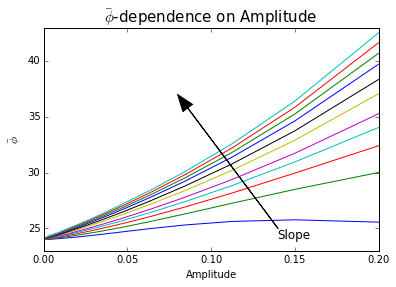

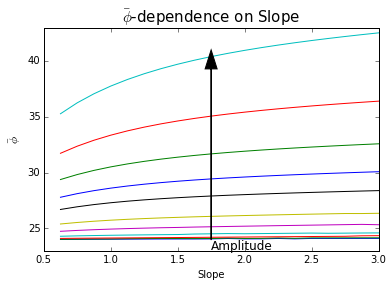

In [59]:
plt.figure()
plt.annotate('Slope',xy = (0.4,0.7),xycoords='axes fraction', 
             xytext=(0.7,0.1),textcoords='axes fraction',
             arrowprops=dict(facecolor='black',shrink=0.0001,width=0.01),
            horizontalalignment='left', verticalalignment='top',fontsize=12)
keArr=[0,1,2,3,4,6,8,11,14,18,23]
for k in keArr:
    #plt.scatter(np.log10(2.*gArr[k,:,0]),np.log10(meanProd[k,:]-24.), color=lArr[k])
    #plt.scatter(2.*epsArr[:,k,0],(meanProd[:,k]-24.), color=lArr[k])
    plt.plot(2.*epsArr[:,k,0],(meanProd[:,k]))#, marker=symArr[k])
plt.title('$\\bar{\\phi}$-dependence on Amplitude',fontsize=15)
plt.xlabel('Amplitude')
plt.ylabel('$\\bar{\\phi}$',fontsize=12)
plt.ylim([23.,43.])
plt.savefig('./figures/epsDep.pdf',format='pdf')
plt.show()

kgArr=[0,5,10,14,17,19,21,22,23,24,25]
plt.figure()
plt.annotate('Amplitude',xy = (0.5,0.9),xycoords='axes fraction', 
             xytext=(0.5,0.05),textcoords='axes fraction',
             arrowprops=dict(facecolor='black',shrink=0.0001,width=0.01),
            horizontalalignment='left', verticalalignment='top',fontsize=12)
for k in kgArr:
    #plt.scatter(np.log10(2.*gArr[k,:,0]),np.log10(meanProd[k,:]-24.), color=lArr[k])
    #plt.scatter(2.*gArr[k,4:,0],(meanProd[k,4:]-24.), color=lArr[k])
    plt.plot(2.*gArr[k,4:,0],(meanProd[k,4:]))
plt.title('$\\bar{\\phi}$-dependence on Slope',fontsize=15)
plt.xlabel('Slope')
plt.ylabel('$\\bar{\\phi}$',fontsize=12)
plt.ylim([23.,43.])
plt.savefig('./figures/gDep.pdf',format='pdf')
plt.show()


In [ ]:
plt.figure()
lArr = np.random.rand(120).reshape(30,4)
symArr = ["o","v","s","^","*","x","+"]
symArr.extend(symArr);symArr.extend(symArr);
printFolder = '/home/sabarish/Dropbox/reports/2015/transfer/figures/'
'''
for k in range(21):
    #plt.scatter(np.log10(2.*gArr[k,:,0]),np.log10(meanProd[k,:]-24.), color=lArr[k])
    plt.scatter(2.*gArr[k,:,0],(meanProd[k,:]-24.), color=lArr[k])
plt.show()
'''
plt.figure()
#ax = plt.subplot(111)
#ax = plt.axes()
plt.annotate('Slope',xy = (0.4,0.7),xycoords='axes fraction', 
             xytext=(0.7,0.1),textcoords='axes fraction',
             arrowprops=dict(facecolor='black',shrink=0.0001,width=0.01),
            horizontalalignment='left', verticalalignment='top',fontsize=12)
keArr=[0,1,2,3,4,6,8,11,14,18,23]
for k in keArr:
    #plt.scatter(np.log10(2.*gArr[k,:,0]),np.log10(meanProd[k,:]-24.), color=lArr[k])
    #plt.scatter(2.*epsArr[:,k,0],(meanProd[:,k]-24.), color=lArr[k])
    plt.plot(2.*epsArr[:,k,0],(meanProd[:,k]))#, marker=symArr[k])
#plt.title('Amplitude depencence of $\\bar{\\phi}$')
plt.xlabel('Amplitude ($2 \\epsilon$)')
plt.ylabel('$\\bar{\\phi}$')
plt.ylim([23.,43.])
plt.savefig(printFolder+'epsDep.pdf',format='pdf')
plt.show()

kgArr=[0,5,10,14,17,19,21,22,23,24,25]
plt.figure()
plt.annotate('Amplitude',xy = (0.5,0.9),xycoords='axes fraction', 
             xytext=(0.5,0.05),textcoords='axes fraction',
             arrowprops=dict(facecolor='black',shrink=0.0001,width=0.01),
            horizontalalignment='left', verticalalignment='top',fontsize=12)
for k in kgArr:
    #plt.scatter(np.log10(2.*gArr[k,:,0]),np.log10(meanProd[k,:]-24.), color=lArr[k])
    #plt.scatter(2.*gArr[k,4:,0],(meanProd[k,4:]-24.), color=lArr[k])
    plt.plot(2.*gArr[k,4:,0],(meanProd[k,4:]))
#plt.title('Slope dependence of $\\bar{\\phi}$')
plt.xlabel('Slope (2g)')
plt.ylabel('$\\bar{\\phi}$')
plt.ylim([23.,43.])
plt.savefig(printFolder+'gDep.pdf',format='pdf')
plt.show()




plt.figure()
nRe = ReWavy[0,0,:].size

#keArr = np.asarray([3,10,20,3,10,20,3,10,20]);kgArr = np.asarray([0,0,0,10,10,10,20,20,20])
"""
for k in range(keArr.size):
    ke = keArr[k]; kg = kgArr[k]
    plt.figure()
    ax1=plt.scatter(ReWavy[ke,kg,:], ReWavy[ke,kg,:]*fricFac[ke,kg,:])
    ax2,=plt.plot(ReWavy[ke,kg,:], np.mean(ReWavy[ke,kg,:]*fricFac[ke,kg,:])*np.ones(nRe))
    ax3,=plt.plot(ReWavy[ke,kg,:], 24.*np.ones(nRe),linestyle='--')
    plt.legend([ax1,ax2,ax3], ['computed', 'mean','flatWall'], loc=2)
    #plt.xlabel('ReBulk'); plt.ylabel('fricFac*ReBulk')
    plt.xlabel('Re'); plt.ylabel('$\bar{\phi}$')
    plt.ylim([23.,29.])
    #plt.title('fricFac*ReBulk for Amplitude:'+str(round(2.*epsArr[ke,0,0],4))+', Slope:'+str(2.*gArr[0,kg,0]) )
    plt.title('$\bar{\phi}$ for Amplitude:'+str(round(2.*epsArr[ke,0,0],4))+', Slope:'+str(2.*gArr[0,kg,0]) )
    plt.savefig(printFolder+'linReg'+str(k)+'.pdf', format='pdf')
"""
keArr = np.asarray([3,11,20]);kgArr = np.asarray([0,10,20])
markers = ['x','+','^']
for k in range(kgArr.size):
    kg = kgArr[k]
    fig = plt.figure(figsize=(7,5))
    ax0 = fig.add_subplot(111)
    ax1=ax0.scatter(ReWavy[keArr[0],kg,:], ReWavy[keArr[0],kg,:]*fricFac[keArr[0],kg,:], marker=markers[0],color='b')
    ax2=ax0.scatter(ReWavy[keArr[1],kg,:], ReWavy[keArr[1],kg,:]*fricFac[keArr[1],kg,:], marker=markers[1],color='g')
    ax3=ax0.scatter(ReWavy[keArr[2],kg,:], ReWavy[keArr[2],kg,:]*fricFac[keArr[2],kg,:], marker=markers[2],color='r')
    #ax2,=plt.plot(ReWavy[ke,kg,:], np.mean(ReWavy[ke,kg,:]*fricFac[ke,kg,:])*np.ones(nRe))
    ax4,=ax0.plot(ReWavy[keArr[0],kg,:], 24.*np.ones(nRe),linestyle='--',color='k')
    plt.legend([ax1,ax2,ax3,ax4], \
               ['Amp:'+str(round(2.*epsArr[keArr[0],0,0],4)),\
                'Amp:'+str(round(2.*epsArr[keArr[1],0,0],4)),\
                'Amp:'+str(round(2.*epsArr[keArr[2],0,0],4)),\
                'flat'], loc=2)
    #plt.xlabel('ReBulk'); plt.ylabel('fricFac*ReBulk')
    plt.xlabel('Re'); plt.ylabel('$\\phi$')
    plt.ylim([23.,30.])
    #plt.title('fricFac*ReBulk for Amplitude:'+str(round(2.*epsArr[ke,0,0],4))+', Slope:'+str(2.*gArr[0,kg,0]) )
    #plt.title('Re-variation of $\\phi$, for Slope:'+str(2.*gArr[0,kg,0]) )
    plt.savefig(printFolder+'linReg'+str(k)+'.pdf', format='pdf')




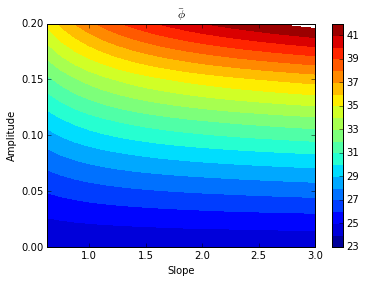

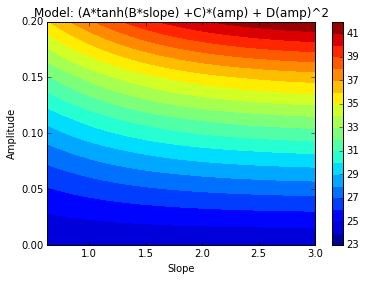

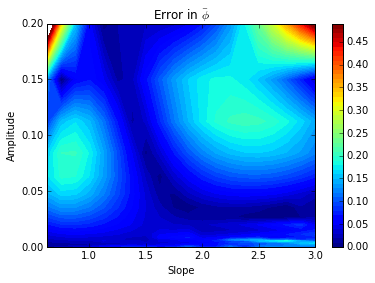

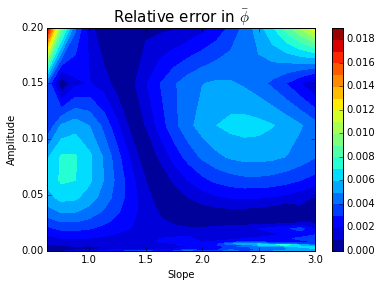

Model coefficients:a=52.275,b=0.619,c=11.831,d=142.348


In [61]:
from scipy.optimize import leastsq

meanData = meanProd[:, 4:]
epsVec2 = 2.*epsArr[:,0,0]; gVec2 = 2.*gArr[0,4:,0]
eps2d = 2.*epsArr[:,4:,0]; g2d = 2.*gArr[:,4:,0]



eps1d = eps2d.reshape(eps2d.size); g1d = g2d.reshape(g2d.size)
meanData1d = meanData.reshape(meanData.size)

def __residuals(params,meanData1d,eps1d, g1d):
    # Fitting meanData to  a*tanh(b*g2d)*eps2d +c*eps2d
    # a = params[0]; b=params[1]; c=params[2]
    #print(params)
    residual = 24+(params[0]*np.tanh(params[1]*g1d) + params[2])*eps1d + params[3]*eps1d**2  - meanData1d
    #residual = params[0]*np.tanh(params[1]*g1d*eps1d) + (params[2] + 48.)*eps1d + 72.*eps1d**2  - meanData1d
    #print ((type(residual)))
    return residual

#print(meanData.shape, eps2d.shape, g2d.shape)
#test = __residuals([70.,1.,10.], meanData, eps2d, g2d)
#print(type(test),test.shape)
pSol = leastsq(__residuals, np.array([20.,1.,50.,1.]), args=(meanData1d,eps1d,g1d))[0]

plt.figure()
plt.contourf(g2d, eps2d,  meanData, levels=np.arange(23.,43.,1.))
plt.colorbar()
plt.title('$\\bar{\\phi}$')
plt.xlabel('Slope'); plt.ylabel('Amplitude')
#plt.savefig('mean.pdf',format='pdf')
#plt.yscale('log')
plt.show()

plt.figure()
plt.contourf(g2d, eps2d, __residuals(pSol, meanData,eps2d,g2d)+meanData, levels=np.arange(23.,43.,1.0))
plt.colorbar()
plt.title('Model: (A*tanh(B*slope) +C)*(amp) + D(amp)^2')
plt.xlabel('Slope'); plt.ylabel('Amplitude')
#plt.yscale('log')
plt.savefig('./figures/model.pdf', format='pdf')
plt.show()

plt.figure()
plt.contourf(g2d, eps2d, np.abs(__residuals(pSol, meanData,eps2d,g2d)), levels=np.arange(0.,0.5,0.01))
plt.colorbar()
plt.title('Error in $\\bar{\\phi}$')
plt.xlabel('Slope'); plt.ylabel('Amplitude')
#plt.yscale('log')
plt.savefig('./figures/modelDiff.pdf', format='pdf')
plt.show()

plt.figure()
plt.contourf(g2d, eps2d, np.abs(__residuals(pSol, meanData,eps2d,g2d)/meanData), levels=np.arange(0.,0.02,0.001))
plt.colorbar()
plt.title('Relative error in $\\bar{\\phi}$',fontsize=15)
plt.xlabel('Slope'); plt.ylabel('Amplitude')
#plt.yscale('log')
plt.savefig('./figures/modelRelDiff.pdf', format='pdf')
plt.show()

print('Model coefficients:a=%1.3f,b=%1.3f,c=%1.3f,d=%1.3f'%(pSol[0],pSol[1],pSol[2], pSol[3]) )



In [62]:
# Printing to ascii for 3-d visualization in tec360:
fricFac2d = fricFac[:,:]; ReWavy2d = ReWavy[:,:]
ReWavy1d = ReWavy2d.reshape(ReWavy2d.size); fricFac1d = fricFac2d.reshape(fricFac2d.size)
eps2d = 2.*epsArr; g2d = 2.*gArr
eps1d = eps2d.reshape(eps2d.size); g1d = g2d.reshape(g2d.size)
modelMean = ((pSol[0]*np.tanh(pSol[1]*g1d) + pSol[2])*eps1d + pSol[3]*eps1d**2)+24.
modelFricFac = modelMean/ReWavy1d
#modelFricFac = ((.*np.tanh(0.6*g1d) + 10.)*eps1d + 136.*eps1d**2)+24.
fricFacDiff = np.abs(modelFricFac-fricFac1d)
fricFacRelDiff = np.abs(modelFricFac-fricFac1d)/fricFac1d

modelDiff = np.abs(modelFricFac - fricFac1d*ReWavy1d)
modelDiffRelative = modelDiff/(fricFac1d*ReWavy1d-24.)

printArr = np.concatenate((ReWavy1d, g1d, eps1d, fricFac1d, modelFricFac, fricFacDiff, fricFacRelDiff), axis=0)
fName='./figures/modelFFv1'
variables = 'VARIABLES = "Re(bulk)", "Slope", "Amplitude", "fricFac","fricFacModel", "fricFacError", "fricFacRelError"\n'
zone = 'ZONE T="", I='+str(ReWavy2d.shape[2])+', J='+str(ReWavy2d.shape[1])+', K='+str(ReWavy2d.shape[0])+', DATAPACKING=POINT \n'
title = 'TITLE= "Product of friction factor and Reynolds number: computed and modeled"\n'
hdr = title+variables+zone

print(type(printArr),printArr.shape)
np.savetxt(fName+'.dat',printArr.reshape(7,printArr.size//7).T, header=hdr,comments='')
print('Printed data to file %s.dat'%fName)



<class 'numpy.ndarray'> (91728,)
Printed data to file ./figures/modelFFv1.dat


In [ ]:
epsVec = epsArr[:-5,0,0]
plt.plot(epsVec,aArr)
plt.title('eps vs a: in mean = a*tanh(b*g) +c')
plt.xlabel('eps'); plt.ylabel('a');plt.show()


plt.figure()
plt.plot(epsVec,bArr)
plt.title('eps vs b in mean = a*tanh(b*g) +c')
plt.xlabel('eps'); plt.ylabel('b');plt.show()

plt.figure()
plt.plot(epsVec,cArr)
plt.title('eps vs c in mean = a*tanh(b*g) +c')
plt.xlabel('eps'); plt.ylabel('c');plt.show()


In [ ]:
linFun = lambda xData,k: k*xData
sqrtFun = lambda xData,k: k*np.sqrt(xData)

aCoeff,pcov = curve_fit(linFun,epsVec, aArr, p0=100.)
bCoeff,pcov = curve_fit(sqrtFun, epsVec,bArr)
cCoeff,pcov = curve_fit(linFun, epsVec, cArr,p0=20.)

print(aCoeff, bCoeff,cCoeff)

In [ ]:
epsArr2 = epsArr[:,:,0]; gArr2 = gArr[:,:,0]
curveFitted = 24.+ cCoeff*epsArr2 + aCoeff*epsArr2*np.tanh(bCoeff*np.sqrt(epsArr2)*2.*gArr2)
originalData = meanProd[:-5]

plt.contourf(2.*gArr2, 4.*epsArr2,originalData-24.)
plt.title('Original data (mean-24)')
plt.xlabel('slope=2*g'); plt.ylabel('crest-trough amplitude = 4*eps')
plt.colorbar(); plt.show()


plt.figure()
plt.contourf(2.*gArr2, 4.*epsArr2, curveFitted-24.)
plt.title('Curve fitted data (mean-24)')
plt.xlabel('slope=2*g'); plt.ylabel('crest-trough amplitude = 4*eps')
plt.colorbar(); plt.show()

plt.figure()
plt.contourf(2.*gArr2, 2.*epsArr2, np.abs(curveFitted-originalData))
plt.title('Error')
plt.xlabel('Slope'); plt.ylabel('Amplitude')
plt.colorbar(); plt.show()

plt.figure()
plt.contourf(2.*gArr2, 2.*epsArr2, np.abs(curveFitted-originalData)/originalData, levels = np.arange(0.,0.4,0.04))
plt.clim([0.,0.2])
plt.xlabel('Slope'); plt.ylabel('Amplitude')
plt.title('Relative Error')
plt.colorbar(); plt.show()
